In [410]:
from derivatives import (
    first_derivative,
    second_derivative,
    )
from scipy.integrate import solve_ivp
from scipy.linalg import solve
from sklearn.gaussian_process import kernels
import matplotlib.pyplot as plt 
import numpy as np
import sklearn
import jax.numpy as jnp
import jax

In [411]:
# %% PDE Heat Diffusion Equation
a = 0.005
l = .1
L = 1
Nx = 500
dx = L / (Nx - 1)
x = np.linspace(0, L, Nx)
u0 = np.exp((-np.sin(np.pi * x)**2)/2)
t_span = (0, 10)
t_eval = np.linspace(0, 10, 500)
#f = np.cos(2 * np.pi * x)

def f(x):
    return np.cos(2 * np.pi * x)

def diffusion(t, u, a, dx):
    u[0] = 0
    u[-1] = 0
    uxx = second_derivative(u, dx)
    ut = a * uxx + a * u**2 + f(x)
    return np.array(ut)

u_diff = []
u_diff.append(solve_ivp(diffusion, t_span=t_span, y0 = u0, args=(a, dx), t_eval=t_eval).y.T)
u_diff = np.squeeze(u_diff)

m, n = u_diff.shape


In [412]:
u_diff = sklearn.preprocessing.normalize(u_diff)
u_diff_noisy_normal = u_diff + np.random.normal(scale=0.01, size=(m, n))
# u_diff_noisy_normal = sklearn.preprocessing.normalize(u_diff_noisy_normal)

In [413]:
# %% Smoothing
## Kernels
x = x[:, None]
#y = t_eval[:, None]
#X=np.array([t_eval,x])


In [414]:
def kernel_smoothing(x: np.array, y: np.array, kernel: str, deg: int=1, param: float=1.0) -> np.array:
    """
    Use to select a kernel for smoothing. input for kernel is either rbf or poly. deg is the degree for the polynomial kernel. param is
    either lengthscale for rbf kernel or c coefficient for polynomial kernel.
    """
    if kernel == 'rbf':
        rbf = kernels.RBF(length_scale=param)
        return rbf(x,y)
    elif kernel == 'poly':
        return sklearn.metrics.pairwise.polynomial_kernel(X=x,Y=y,degree=deg, coef0=param,gamma=1)
    else:
        raise ValueError("Kernel choices are rbf or poly")

<Figure size 640x480 with 0 Axes>

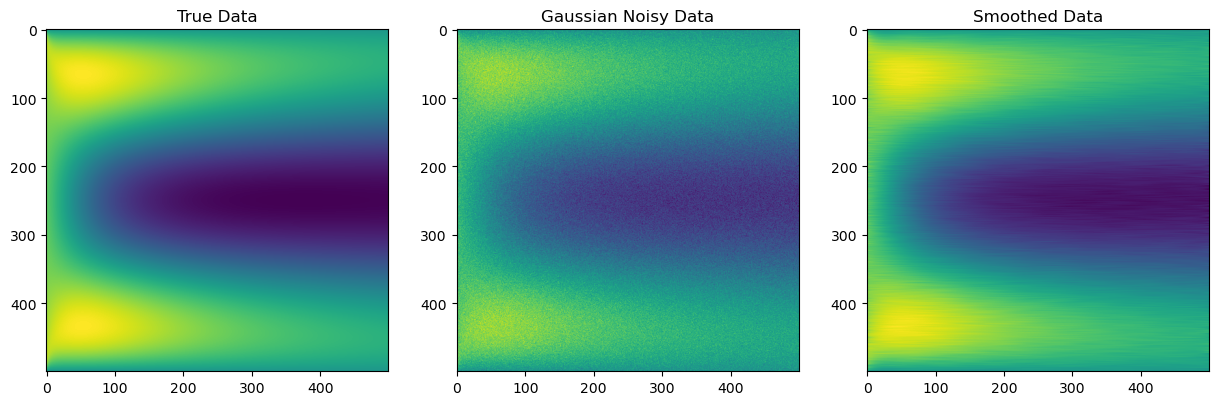

In [415]:
# u_rbf = sklearn.metrics.pairwise.polynomial_kernel(x)
deg = 2
param = .1
sk = kernel_smoothing(x=x,y=x,kernel='rbf',param=param,deg=deg)
u_diff_smooth_normal = sk @ solve((sk + 0.003*np.eye(Nx)), u_diff_noisy_normal)
plt.figure()
fig, axis = plt.subplots(1, 3, figsize=(15, 5))
axis[0].imshow(u_diff.T)
axis[0].set_title('True Data')
axis[1].imshow(u_diff_noisy_normal.T)
axis[1].set_title('Gaussian Noisy Data')
axis[2].imshow(u_diff_smooth_normal.T)
axis[2].set_title('Smoothed Data')
plt.show()

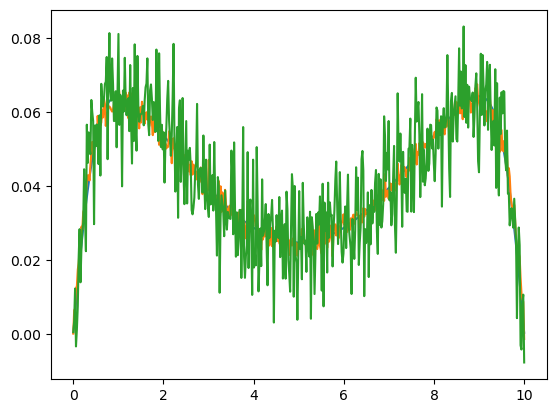

In [416]:
plt.plot(t_eval,u_diff[10:11,:].squeeze())
plt.plot(t_eval,u_diff_smooth_normal[10:11,:].squeeze())
plt.plot(t_eval,u_diff_noisy_normal[10:11,:].squeeze())

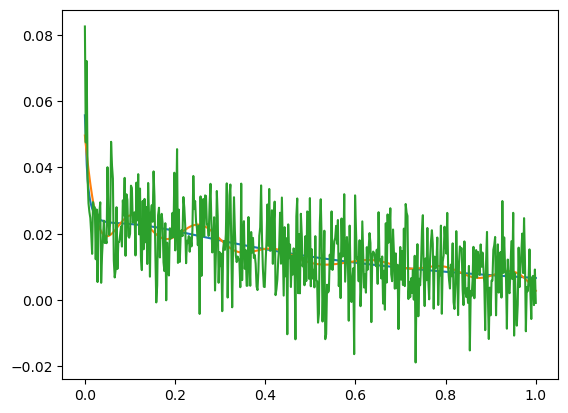

In [417]:
plt.plot(x,u_diff[:,10:11].squeeze())
plt.plot(x,u_diff_smooth_normal[:,10:11].squeeze())
plt.plot(x,u_diff_noisy_normal[:,10:11].squeeze())

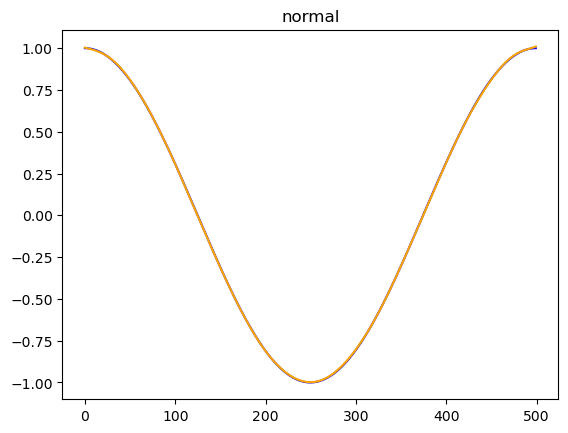

In [418]:
# %% Kernels and Functional Form of PDE
#reg_l = 1
#rbf = kernels.RBF(length_scale=l)
# poly = sklearn.metrics.pairwise.polynomial_kernel(degree=2, coef0=.23)
def P(S, s, P_coef):
    K_sS = sklearn.metrics.pairwise.polynomial_kernel(X=S,Y=s,degree=2, coef0=.5,gamma=1)
    return K_sS @ P_coef

f = f(x)
# f = np.zeros_like(x)
SS = np.random.random((200, 600))

param1=1.5
sk_ux = kernel_smoothing(x=x,y=x,kernel='rbf',param=param1,deg=deg)

u_kx_normal = jnp.gradient(sk,axis=0) @ solve(
    (sk + 0.1*np.eye(Nx)), u_diff_smooth_normal
    )
u_kxx_normal = jnp.gradient(jnp.gradient(sk,axis=0),axis=0) @ solve(
    (sk + 0.1*np.eye(Nx)), u_diff_smooth_normal
    )
s_normal = np.hstack([x, u_diff_smooth_normal, u_kx_normal, u_kxx_normal])
K_normal = sklearn.metrics.pairwise.polynomial_kernel(X=s_normal,Y=s_normal,degree=2, coef0=.5,gamma=1)
P_coef_normal = solve((K_normal + 0.003 * np.eye(Nx)), f)
f_new_normal = P(s_normal, s_normal, P_coef_normal)

plt.figure()
plt.title("normal")
plt.plot(f,color='blue')
plt.plot(f_new_normal, color='orange')

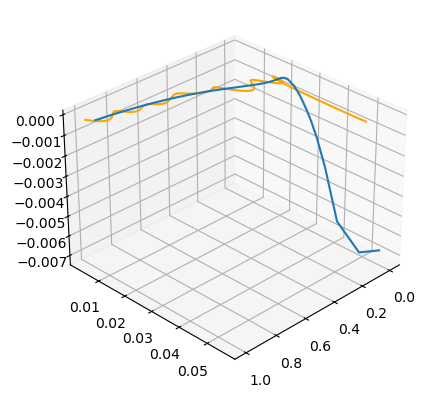

In [419]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(x.squeeze(),u_diff_smooth_normal[:,10:11].squeeze(),u_kx_normal[:,10:11].squeeze(),color='orange')
ax.plot(x.squeeze(),u_diff[:,10:11].squeeze(),jnp.gradient(u_diff[:,10:11].squeeze()))
ax.view_init(azim=45, elev=30)

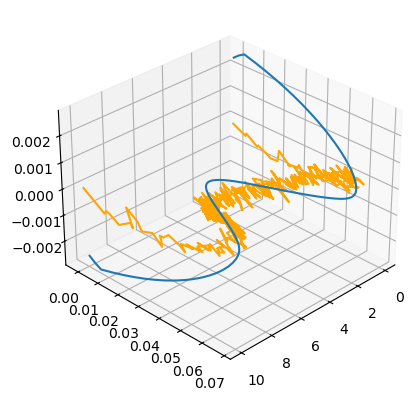

In [420]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(t_eval,u_diff_smooth_normal[10:11,:].squeeze(),u_kx_normal[10:11,:].squeeze(),color='orange')
ax.plot(t_eval,u_diff[10:11,:].squeeze(),jnp.gradient(u_diff[10:11,:].squeeze()))
ax.view_init(azim=45, elev=30)

In [421]:
u_diff_ux = jnp.gradient(u_diff,axis=0)

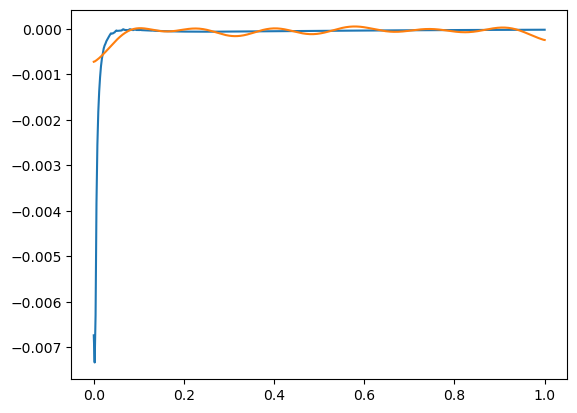

In [422]:
plt.plot(x,u_diff_ux[:,10:11].squeeze())
plt.plot(x,u_kx_normal[:,10:11].squeeze())
